In [1]:
# Importing necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
# Set paths to dataset directories
base_dir = '/Users/abdullah/Desktop/WildFireProject/wildfire-dataset'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

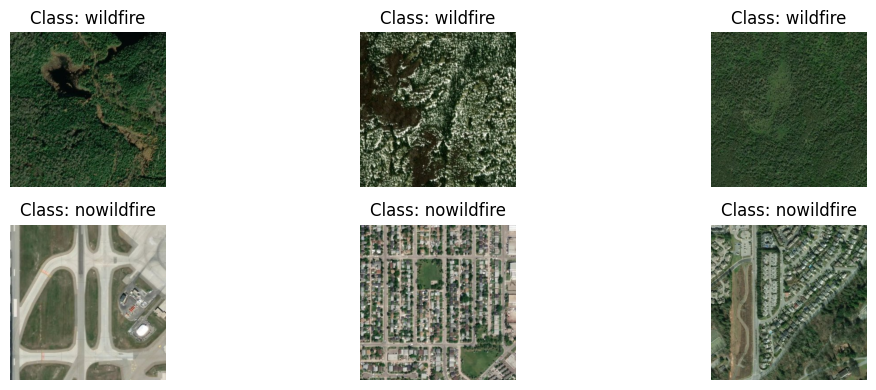

In [3]:
# Visualizing sample images
def visualize_images(directory, samples_per_class=3): # 3 samples each class 3 * 'NO'  - 3 * 'YES'
    plt.figure(figsize=(12, 4))
    subdirs = ['wildfire', 'nowildfire']
    for idx, subdir in enumerate(subdirs):
        subdir_path = os.path.join(directory, subdir) # creating thje full path for the subdirectory
        files = os.listdir(subdir_path)[:samples_per_class]
        for i, file in enumerate(files):
            img_path = os.path.join(subdir_path, file)
            img = plt.imread(img_path)
            plt.subplot(len(subdirs), samples_per_class, idx * samples_per_class + i + 1)
            # 2 rows
            # 3 cols

            plt.imshow(img)
            plt.title(f"Class: {subdir}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize images from the training directory
visualize_images(train_dir)



In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

In [5]:
# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 30249 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6299 images belonging to 2 classes.


In [24]:
from tensorflow.keras.regularizers import l2

# Defining the CNN model
def create_cnn_model():
    model = Sequential([
        # Added L2 regularization to help prevent overfitting
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(64, 64, 3)),        
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),

        Flatten(),  # Flatten layer to convert 2D feature maps into a 1D feature vector
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),  # Increased dropout rate from 0.3 to 0.4 to reduce overfitting

        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])

    # Compile the model with Adam optimizer and binary crossentropy loss
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

cnn_model = create_cnn_model()

In [25]:
# Callbacks for training
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('wildfire_detection_model.keras', monitor='val_accuracy', save_best_only=True)


# the callbacks overhere are checking for best accurancy detection, in other word "outliers started to be shown, stop the training to not affect our validation results"

Preproccessing

In [26]:
import os
from PIL import Image

def verify_images(directory):
    subdirs = ['wildfire', 'nowildfire']
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            img_path = os.path.join(subdir_path, file)
            try:
                img = Image.open(img_path)
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                print(f'Bad file found: {img_path}')
                os.remove(img_path)  # Remove the corrupted image

# Run this function on your train, valid, and test directories
base_dir = '/Users/abdullah/Desktop/WildFireProject/wildfire-dataset'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

verify_images(train_dir)
verify_images(valid_dir)
verify_images(test_dir)

In [27]:
import os
from PIL import Image

def open_all_images(directory):
    subdirs = ['wildfire', 'nowildfire']
    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        files = os.listdir(subdir_path)
        for file in files:
            img_path = os.path.join(subdir_path, file)
            try:
                img = Image.open(img_path)
                img.load()  # Force loading of image data
            except Exception as e:
                print(f'Error opening image {img_path}: {e}')
                os.remove(img_path)  # Remove the corrupted image

# Run this function to remove the problematic images
open_all_images(train_dir)
open_all_images(valid_dir)
open_all_images(test_dir)

In [28]:
# Reinitialize the data generators after deleting corrupted images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 30249 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6299 images belonging to 2 classes.


In [29]:
# Training the CNN model
history = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=25,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[lr_reduction, early_stopping, model_checkpoint]
)

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


945/945 ━━━━━━━━━━━━━━━━━━━━ 63s 65ms/step - accuracy: 0.8771 - loss: 1.9623 - val_accuracy: 0.8742 - val_loss: 0.4168 - learning_rate: 0.0010
Epoch 2/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.9062 - loss: 0.1355 - val_accuracy: 0.8571 - val_loss: 0.2327 - learning_rate: 0.0010
Epoch 3/25


2024-09-03 15:08:22.990330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-03 15:08:23.060552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9112 - loss: 0.3150
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
945/945 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.9112 - loss: 0.3150 - val_accuracy: 0.8273 - val_loss: 0.5161 - learning_rate: 0.0010
Epoch 4/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step - accuracy: 0.8750 - loss: 0.1425 - val_accuracy: 0.8929 - val_loss: 0.1721 - learning_rate: 5.0000e-04
Epoch 5/25


2024-09-03 15:09:30.152678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:09:30.245665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 69s 72ms/step - accuracy: 0.9267 - loss: 0.2507 - val_accuracy: 0.9346 - val_loss: 0.2256 - learning_rate: 5.0000e-04
Epoch 6/25
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.9688 - loss: 0.0754 - val_accuracy: 1.0000 - val_loss: 0.0843 - learning_rate: 5.0000e-04
Epoch 7/25


2024-09-03 15:10:38.977059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:10:39.057080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 67s 70ms/step - accuracy: 0.9281 - loss: 0.2360 - val_accuracy: 0.9201 - val_loss: 0.2523 - learning_rate: 5.0000e-04
Epoch 8/25
  1/945 ━━━━━━━━━━━━━━━━━━━━ 53s 57ms/step - accuracy: 1.0000 - loss: 0.1155
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 1.0000 - loss: 0.0578 - val_accuracy: 0.8571 - val_loss: 0.2171 - learning_rate: 5.0000e-04
Epoch 9/25


2024-09-03 15:11:45.932511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:11:45.950986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 67s 70ms/step - accuracy: 0.9366 - loss: 0.2090 - val_accuracy: 0.9397 - val_loss: 0.2038 - learning_rate: 2.5000e-04
Epoch 10/25
  1/945 ━━━━━━━━━━━━━━━━━━━━ 55s 58ms/step - accuracy: 0.9688 - loss: 0.1512
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.9688 - loss: 0.0757 - val_accuracy: 1.0000 - val_loss: 0.0522 - learning_rate: 2.5000e-04
Epoch 11/25


2024-09-03 15:12:52.839922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:12:52.857342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 72s 75ms/step - accuracy: 0.9404 - loss: 0.2002 - val_accuracy: 0.9367 - val_loss: 0.2274 - learning_rate: 1.2500e-04
Epoch 12/25
  1/945 ━━━━━━━━━━━━━━━━━━━━ 58s 62ms/step - accuracy: 0.9062 - loss: 0.1984
Epoch 12: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.9062 - loss: 0.0993 - val_accuracy: 0.9643 - val_loss: 0.0652 - learning_rate: 1.2500e-04
Epoch 13/25


2024-09-03 15:14:04.611150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:14:04.629790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 73s 77ms/step - accuracy: 0.9429 - loss: 0.1889 - val_accuracy: 0.9471 - val_loss: 0.1834 - learning_rate: 6.2500e-05
Epoch 14/25
  1/945 ━━━━━━━━━━━━━━━━━━━━ 49s 53ms/step - accuracy: 0.9688 - loss: 0.0850
Epoch 14: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.9688 - loss: 0.0426 - val_accuracy: 1.0000 - val_loss: 0.0261 - learning_rate: 6.2500e-05
Epoch 15/25


2024-09-03 15:15:17.887538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:15:17.907991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 74s 78ms/step - accuracy: 0.9466 - loss: 0.1850 - val_accuracy: 0.9491 - val_loss: 0.1856 - learning_rate: 3.1250e-05
Epoch 16/25
  1/945 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - accuracy: 0.9688 - loss: 0.1216
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.9688 - loss: 0.0609 - val_accuracy: 1.0000 - val_loss: 0.0289 - learning_rate: 3.1250e-05
Epoch 17/25


2024-09-03 15:16:31.935769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:16:31.954290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 77s 81ms/step - accuracy: 0.9454 - loss: 0.1818 - val_accuracy: 0.9490 - val_loss: 0.1757 - learning_rate: 1.5625e-05
Epoch 18/25
  1/945 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.9688 - loss: 0.2195
Epoch 18: ReduceLROnPlateau reducing learning rate to 1e-05.
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.9688 - loss: 0.1099 - val_accuracy: 0.9286 - val_loss: 0.1300 - learning_rate: 1.5625e-05
Epoch 19/25


2024-09-03 15:17:48.740826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-09-03 15:17:48.758170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


945/945 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - accuracy: 0.9472 - loss: 0.1785 - val_accuracy: 0.9509 - val_loss: 0.1785 - learning_rate: 1.0000e-05


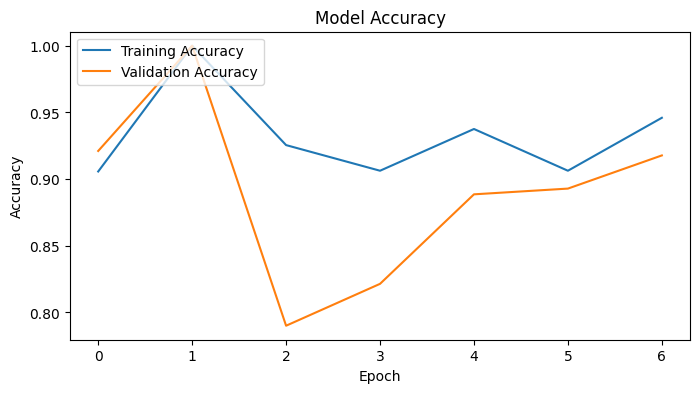

In [12]:
# Plotting the training & validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

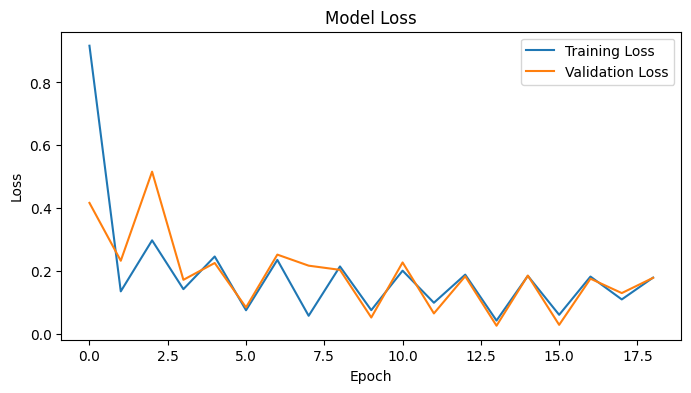

In [30]:
# Plotting the training & validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [31]:
# Evaluating the model on test data
scores = cnn_model.evaluate(test_generator)
print(f'Test accuracy: {scores[1] * 100:.2f}%')

# Saving the trained model
cnn_model.save('wildfire_detection_cnn_model.h5')

# Classification Report
test_generator.reset()
y_pred = cnn_model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(test_generator.classes, y_pred, target_names=['nowildfire', 'wildfire']))

197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9605 - loss: 0.1434


Test accuracy: 95.70%
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
              precision    recall  f1-score   support

  nowildfire       0.95      0.95      0.95      2820
    wildfire       0.96      0.96      0.96      3479

    accuracy                           0.96      6299
   macro avg       0.96      0.96      0.96      6299
weighted avg       0.96      0.96      0.96      6299



In [32]:
import os

img_path = '/Users/abdullah/Desktop/WildFireProject/test_image.jpg'
if not os.path.exists(img_path):
    print("The image file does not exist at the provided path.")

In [33]:
import os
img_path = '/Users/abdullah/Desktop/WildFireProject/test_image.jpg'
print(os.path.exists(img_path))  # This should return True if the file exists

True


In [34]:
from PIL import Image

try:
    img = Image.open(img_path)
    img.show()  # This should open the image in the default image viewer
except Exception as e:
    print(f"Error opening image: {e}")

In [35]:
# Load and predict a new image

def predict_image(img_path):
    image = cv2.imread(img_path)
    image_resized = cv2.resize(image, (64, 64))
    image_normalized = image_resized / 255.0
    image_reshaped = np.reshape(image_normalized, (1, 64, 64, 3))
    
    prediction = cnn_model.predict(image_reshaped)
    predicted_class = 'wildfire' if prediction[0][0] > 0.5 else 'nowildfire'
    
    print(f"The model predicts this image as a '{predicted_class}' case.")

# Example usage
img_path = '/Users/abdullah/Desktop/WildFireProject/wildfire-dataset/test/wildfire/-61.87285,47.36931.jpg'  # Replace with the actual image path
predict_image(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
The model predicts this image as a 'nowildfire' case.


In [19]:
#Saving the Model to use in Flask and make a website that depends in this model.
cnn_model.save('WildfireCnn.keras')